In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

###### Using LinReg predict add-to-order ratio

In [2]:
#Prepare DataFrame
aisle = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
train = pd.read_csv('order_train.csv')

In [3]:
#Spark Initiation
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("InstacartData") \
        .getOrCreate()

In [4]:
df_aisle = spark.createDataFrame(aisle)
df_departments = spark.createDataFrame(departments)
df_products = spark.createDataFrame(products)
df_orders = spark.createDataFrame(orders)
df_train = spark.createDataFrame(train)

In [5]:
df_train.printSchema()

root
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- add_to_cart_order: long (nullable = true)
 |-- reordered: long (nullable = true)



In [6]:
order_ratio = df_train.select('add_to_cart_order','reordered') \
            .groupBy('add_to_cart_order') \
            .agg({"reordered":"mean"}) \
            .withColumnRenamed('avg(reordered)','reorder_ratio') \
            .filter(df_train.add_to_cart_order < 50) \
            .sort('add_to_cart_order')
co_result = order_ratio.toPandas()
assembler = VectorAssembler(inputCols = ["add_to_cart_order"],
                           outputCol="features")
output = assembler.transform(order_ratio)

In [7]:
# Fit linear regression
linreg = LinearRegression() \
  .setLabelCol("reorder_ratio")
lrModel = linreg.fit(output)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [-0.006079664022656915]
Intercept: 0.635881186938825


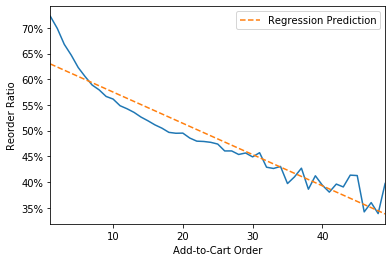

In [8]:
co_plot = co_result.plot(x = 'add_to_cart_order', y = 'reorder_ratio', label = 'Real Value')
prediction_values = [lrModel.coefficients * i + lrModel.intercept for i in co_result.add_to_cart_order]
prediction = plt.plot(co_result.add_to_cart_order, prediction_values, label='Regression Prediction', linestyle='--')
co_plot.set_ylabel("Reorder Ratio")
co_plot.set_xlabel("Add-to-Cart Order")
plt.legend(handles = prediction)
co_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

###### What aisles are frequenly bought together?

In [10]:
aisle_order = df_train.join(df_products,df_products.product_id ==df_train.product_id) \
            .join(df_aisle, df_aisle.aisle_id == df_products.aisle_id) \
            .select(df_train.order_id, df_aisle.aisle) \
            .filter("aisle NOT LIKE '%fruits' AND aisle NOT LIKE '%vegetables'") \
            .dropDuplicates() \
            .persist()

In [11]:
print("Transformation:")
aisle_order.show(10)

Transformation:
+--------+------+
|order_id| aisle|
+--------+------+
| 3236948|coffee|
| 3334306|coffee|
| 2833450|coffee|
| 1807947|coffee|
| 1328800|coffee|
|    4468|coffee|
| 3163338|coffee|
| 2483455|coffee|
| 1966767|coffee|
|  761521|coffee|
+--------+------+
only showing top 10 rows



In [12]:
transection = aisle_order.groupBy(aisle_order.order_id) \
              .agg({'aisle':'collect_list'}) \
              .withColumnRenamed('collect_list(aisle)','items') \
              .persist()

In [16]:
print("After Transformation :")
transection.show(5, truncate=100)

After Transformation :
+--------+----------------------------------------------------------------------------------------------------+
|order_id|                                                                                               items|
+--------+----------------------------------------------------------------------------------------------------+
|    3091|                                                     [nuts seeds dried fruit, tea, breakfast bakery]|
|    4590|     [energy granola bars, frozen meals, fresh dips tapenades, trail mix snack mix, packaged cheese]|
|   10156|[packaged cheese, yogurt, pasta sauce, breakfast bakery, frozen vegan vegetarian, dry pasta, soy ...|
|   13248|[soup broth bouillon, pasta sauce, tea, cereal, frozen meals, fresh dips tapenades, frozen appeti...|
|   16530|                      [refrigerated, asian foods, juice nectars, fresh herbs, prepared soups salads]|
+--------+-----------------------------------------------------------------------

In [22]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol = "items", minSupport=0.05, minConfidence = 0)
model = fpGrowth.fit(transection)

In [23]:
model.freqItemsets.show(truncate=100) #Display frequent items

+------------------------------------------------+-----+
|                                           items| freq|
+------------------------------------------------+-----+
|                                        [yogurt]|33249|
|                               [packaged cheese]|31199|
|                       [packaged cheese, yogurt]|11548|
|                                          [milk]|29358|
|                         [milk, packaged cheese]|10013|
|                                  [milk, yogurt]|11414|
|                 [water seltzer sparkling water]|26943|
|[water seltzer sparkling water, packaged cheese]| 6944|
|         [water seltzer sparkling water, yogurt]| 7632|
|                                [chips pretzels]|23182|
|               [chips pretzels, packaged cheese]| 7994|
|                        [chips pretzels, yogurt]| 7638|
|                               [soy lactosefree]|22373|
|                       [soy lactosefree, yogurt]| 7680|
|                              

In [25]:
#Show generated association rules
model.associationRules.sort('confidence', ascending = False).show(50, truncate=100)

+-------------------------------+-------------------------------+-------------------+------------------+
|                     antecedent|                     consequent|         confidence|              lift|
+-------------------------------+-------------------------------+-------------------+------------------+
|                   [lunch meat]|              [packaged cheese]|0.45711678832116787|1.8886268229166057|
|                         [milk]|                       [yogurt]|0.38878670209142313|1.5072749097112281|
|                        [bread]|              [packaged cheese]| 0.3750465376023827|1.5495448184243834|
|                        [bread]|                       [yogurt]| 0.3703462397617275|1.4357836625993623|
|              [packaged cheese]|                       [yogurt]|0.37014006859194204| 1.434984364090304|
|                         [eggs]|                       [yogurt]| 0.3622079801529874|1.4042327004625816|
|                        [bread]|                      